## **Búsqueda por párrafo - Corte Constitucional**

## **Importación de librerías**

In [1]:
import gensim
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import spacy

from gensim import corpora, models
from gensim.corpora.dictionary import Dictionary
from gensim.models import FastText
from gensim.models.ldamulticore import LdaMulticore
from gensim.parsing.preprocessing import STOPWORDS
from gensim.test.utils import common_texts
from gensim.test.utils import datapath
from multiprocessing import Pool
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from string import punctuation
from tqdm import tqdm

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
nltk.download('stopwords')
nlp = spacy.load("es_core_news_md")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/caicardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Definición de funciones**

In [3]:
ABC = 'abcdefghijklmnñopqrstuvwxyzáéíóúü0123456789 '
regex_pattern = "[^{0}{1}_]".format(ABC, ABC.upper())
sentence_regex_pattern = "[^{0}{1}_.\n]".format(ABC, ABC.upper())

In [4]:
def old_preprocessor(text):
    """
    preprocesador de texto
    """
    if not isinstance(text, str):
        return ""
    
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~ºª'''
    for char in punctuations:
        text = text.replace(char, " ")
    
    text = re.sub("\s+", " ", text)
    text = text.strip().lower()
    text = re.sub("\d+", "<NUM>", text)
    return text

In [5]:
def preprocessor(text):
    """
    preprocesador de texto
    """
    if not isinstance(text, str):
        return ""
    
    text = re.sub(regex_pattern, " ", text)
    text = re.sub("\s+", " ", text)
    text = text.strip().lower()
    text = re.sub("\d+", "<NUM>", text)
    return text

In [37]:
def preprocessor_sentences(text, debug=False):
    """
    preprocesador de texto con separación de frases por línea.
    """
    if not isinstance(text, str):
        return ""
    
    text = re.sub(sentence_regex_pattern, " ", text)
    if debug:
        print("Replace regex pattern:\n", text)
    text = re.sub("\d+", "<NUM>", text)
    if debug:
        print("Replace numbers:\n", text)
    text = text.replace("\n\n", "<FIN>")
    if debug:
        print("Tag double end_line as sentence end:\n", text)
    text = text.replace(".", "<FIN>")
    if debug:
        print("ag full stops as sentence end:\n", text)
    text = re.sub("\s+", " ", text)
    if debug:
        print("Replace whitespace for space:\n", text)
    text = text.replace("<FIN>", "\n")
    if debug:
        print("Replace line end tag for line end:\n", text)
    text = "".join([c for c in text if str.isprintable(c) or c=="\n" or c=="."])
    if debug:
        print("Remove non printable chars:\n", text)
    text = re.sub("[\n\r]+", "\n", text)
    if debug:
        print("Replace multiple line changes for a single one:\n", text)
    text = text.lower()
    if debug:
        print("Lowercase:\n", text)
    text = text.strip("\n ")
    if debug:
        print("Strip :\n", text)
    return text

In [266]:
def wv_vectorizer(text):
    """
    Calcula el vector promedio de las palabras de la frase.
    """
    text = preprocessor(text)
    vec_list = []
    for word in [w for w in text.split() if w not in es_stopwords]:
        vec_list.append(model.wv[word])
    if len(vec_list)==0:
        return np.random.random(model.wv.vector_size)
    vec_list = np.array(vec_list)
    norms = np.linalg.norm(vec_list, axis=1).reshape(-1,1)
    norms = np.array([n if n>0 else 1.0 for n in norms])
    vec_over_norm = vec_list/norms
    vec = np.mean(vec_over_norm, axis=0)
    return vec

In [8]:
def remove_stopwords(text):
    tokens = text.split()
    out = " ".join([word for word in tokens if word not in es_stopwords])
    return out

In [9]:
def lemmatize(text):
    nlp_tokens = nlp(text)
    lemma = [w.lemma_ for w in nlp_tokens]
    lemma = " ".join(lemma)
    return lemma
    

In [10]:
def transform_token(token):
    if token.is_stop:
        return "<STOP>" + token.text
    if token.pos_!= 'PROPN':
        return token.lemma_
    return token.text


def full_preprocess(text, debug=False):
    """
    Performs lemmatization, stopword removal via spacy and custom list and preprocessing
    """
    text = re.sub("\s+", " ", text)
    nlp_tokens = nlp(text)
    mask = [w.pos_ for w in nlp_tokens]
    spacy_pp = [transform_token(w) for w in nlp_tokens]

    joint_spp = spacy_pp[0]
    for i in range(1, len(mask)):
        joint_spp = "".join([joint_spp, "_" if (mask[i]=='PROPN' and mask[i-1]=='PROPN') else " ", spacy_pp[i]])

    joint_spp = " ".join([w for w in joint_spp.split() if not w.startswith("<STOP>")])

    preprocessed = preprocessor(joint_spp)

    out = remove_stopwords(preprocessed)
    return out


## **Configuración**

In [11]:
RANDOM_STATE = 42
N_TOP_DOCS = 5
CARACTERES = 500

In [12]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [13]:
# DATA_PATH = './scrappy/'
DATA_PATH = "data/cc_dump_p.csv"

In [14]:
es_stopwords = nltk.corpus.stopwords.words("spanish")

In [15]:
es_stopwords.remove("no")

In [16]:
es_stopwords.append("<NUM>")

## **Lectura de datos**

In [17]:
df = pd.read_csv(DATA_PATH)

In [18]:
df.rename({"class":"class_", "name":"sentencia"}, axis=1, inplace=True)

In [19]:
df.head()

,Unnamed: 0,p_index,tag,text,class_,sentencia,link
0,0,0,h5,Sentencia T-120/05,no_class,T-120-05,Relatoria/2005/T-120-05.htm
1,1,2,p,PROPIEDAD HORIZONTAL-Obligaciones a cargo de l...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm
2,2,4,p,ADMINISTRACION DE PROPIEDAD HORIZONTAL-No pago...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm
3,3,6,p,CUOTAS DE ADMINISTRACION-Compra de inmueble en...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm
4,4,9,p,Referencia: expediente T-992178,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm


In [20]:
len(df)

6587045

In [21]:
df = df[[isinstance(x, str) for x in df.text.values]]

In [22]:
len(df)

6586593

## **Revisión para separación por frases de cada párrafo**

In [33]:
id_ejemplo = 1111

In [39]:
print("Original:\n", df.iloc[id_ejemplo].text)

Original:
 De la misma manera, el Juzgado demandado
afirma que la decisión de la Comisaría de Familia en la que se sanciona al
señor Jesús Arnulfo Grandas Duarte no podría tenerse en cuenta por cuanto
considera que la actuación de la entidad no fue la correcta. Al respecto se
reitera que aunque el trámite correcto no haya sido decretar de nuevo una
medida de protección provisional, tampoco podría por tal motivo desconocer que
el señor Grandas Duarte había incurrido de nuevo en actos violentos contra la
accionante y establecer arbitrariamente que no había incumplido la medida de
protección de 24 de septiembre de 2012, dejando no solo sin sanción al
demandado sino sin protección y en estado de vulneración a la señora Nubia
Mercedes Mateus Hernández.


In [38]:
preprocessor_sentences(df.iloc[id_ejemplo].text, debug=True)

Replace regex pattern:
 De la misma manera  el Juzgado demandado 
afirma que la decisión de la Comisaría de Familia en la que se sanciona al 
señor Jesús Arnulfo Grandas Duarte no podría tenerse en cuenta por cuanto 
considera que la actuación de la entidad no fue la correcta. Al respecto se 
reitera que aunque el trámite correcto no haya sido decretar de nuevo una 
medida de protección provisional  tampoco podría por tal motivo desconocer que 
el señor Grandas Duarte había incurrido de nuevo en actos violentos contra la 
accionante y establecer arbitrariamente que no había incumplido la medida de 
protección de 24 de septiembre de 2012  dejando no solo sin sanción al 
demandado sino sin protección y en estado de vulneración a la señora Nubia 
Mercedes Mateus Hernández.
Replace numbers:
 De la misma manera  el Juzgado demandado 
afirma que la decisión de la Comisaría de Familia en la que se sanciona al 
señor Jesús Arnulfo Grandas Duarte no podría tenerse en cuenta por cuanto 
consider

'de la misma manera el juzgado demandado afirma que la decisión de la comisaría de familia en la que se sanciona al señor jesús arnulfo grandas duarte no podría tenerse en cuenta por cuanto considera que la actuación de la entidad no fue la correcta\n al respecto se reitera que aunque el trámite correcto no haya sido decretar de nuevo una medida de protección provisional tampoco podría por tal motivo desconocer que el señor grandas duarte había incurrido de nuevo en actos violentos contra la accionante y establecer arbitrariamente que no había incumplido la medida de protección de <num> de septiembre de <num> dejando no solo sin sanción al demandado sino sin protección y en estado de vulneración a la señora nubia mercedes mateus hernández'

In [41]:
preprocessor_sentences(df.iloc[id_ejemplo].text).split('\n')

['de la misma manera el juzgado demandado afirma que la decisión de la comisaría de familia en la que se sanciona al señor jesús arnulfo grandas duarte no podría tenerse en cuenta por cuanto considera que la actuación de la entidad no fue la correcta',
 ' al respecto se reitera que aunque el trámite correcto no haya sido decretar de nuevo una medida de protección provisional tampoco podría por tal motivo desconocer que el señor grandas duarte había incurrido de nuevo en actos violentos contra la accionante y establecer arbitrariamente que no había incumplido la medida de protección de <num> de septiembre de <num> dejando no solo sin sanción al demandado sino sin protección y en estado de vulneración a la señora nubia mercedes mateus hernández']

## **Crear corpus preprocesado para FastText**

#### **Preprocesamiento de texto (para TF-IDF)**

Como el preprocesamiento no toma tanto tiempo, no hay problema en repetirlo, pero en general no es necesario volver a preprocesar los datos, se pueden guardar descomentando el código más abajo.

In [42]:
%%time
with Pool(8) as my_pool:
    pp_list = my_pool.map(preprocessor_sentences, df.text.values)

CPU times: user 10 s, sys: 5.65 s, total: 15.7 s
Wall time: 1min


In [43]:
df["pp"] = pp_list

In [44]:
df.head()

,Unnamed: 0,p_index,tag,text,class_,sentencia,link,pp
0,0,0,h5,Sentencia T-120/05,no_class,T-120-05,Relatoria/2005/T-120-05.htm,sentencia t <num> <num>
1,1,2,p,PROPIEDAD HORIZONTAL-Obligaciones a cargo de l...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm,propiedad horizontal obligaciones a cargo de l...
2,2,4,p,ADMINISTRACION DE PROPIEDAD HORIZONTAL-No pago...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm,administracion de propiedad horizontal no pago...
3,3,6,p,CUOTAS DE ADMINISTRACION-Compra de inmueble en...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm,cuotas de administracion compra de inmueble en...
4,4,9,p,Referencia: expediente T-992178,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm,referencia expediente t <num>


## Stats

In [32]:
print("Cantidad de documentos: {}".format(len(df.sentencia.unique())))

Cantidad de documentos: 34932


In [33]:
df["word_count"] = [len(x.strip().split()) for x in df.text.values]

In [34]:
max_wc = np.max(df.word_count)
max_wc_p = df[df.word_count==max_wc].iloc[0].to_dict()
print("Características del párrafo más largo:")
print("- párrafo {0} de la sentencia {1}.".format(max_wc_p["p_index"], max_wc_p["sentencia"]))
print("- Contiene {} palabras.".format(max_wc_p["word_count"]))

Características del párrafo más largo:
- párrafo 22 de la sentencia T-1532-00.
- Contiene 7456 palabras.


In [35]:
df["class_"] = pd.Categorical(df["class_"])

In [36]:
df["class_"].value_counts()

MsoNormal           4550691
MsoFootnoteText      761740
MsoBodyText          235933
no_class             139539
MsoListParagraph      84887
                     ...   
ecxecxbodytext2           1
ecmsobodytext             1
decretos                  1
de                        1
yiv8754979524             1
Name: class_, Length: 1357, dtype: int64

## **Preprocesamiento de texto (para TF-IDF)**

Como el preprocesamiento no toma tanto tiempo, no hay problema en repetirlo, pero en general no es necesario volver a preprocesar los datos, se pueden guardar descomentando el código más abajo.

In [37]:
%%time
with Pool(8) as my_pool:
    pp_list = my_pool.map(full_preprocess, df.text.values)

CPU times: user 9.75 s, sys: 9.43 s, total: 19.2 s
Wall time: 2h 3min 25s


In [38]:
df["pp"] = pp_list

In [39]:
df.head()

,Unnamed: 0,p_index,tag,text,class_,sentencia,link,word_count,pp
0,0,0,h5,Sentencia T-120/05,no_class,T-120-05,Relatoria/2005/T-120-05.htm,2,sentencia_t
1,1,2,p,PROPIEDAD HORIZONTAL-Obligaciones a cargo de l...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm,27,propiedad_horizontal obligaciones cargo propie...
2,2,4,p,ADMINISTRACION DE PROPIEDAD HORIZONTAL-No pago...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm,10,administracion propiedad_horizontal no pago cu...
3,3,6,p,CUOTAS DE ADMINISTRACION-Compra de inmueble en...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm,14,cuotas administracion compra inmueble remate d...
4,4,9,p,Referencia: expediente T-992178,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm,3,referencia expediente t


**Guardar datos preprocesados**

In [40]:
df.to_csv("data/cc_dump_full_pp_20210508.csv")

## Para datos ya preprocesados, empezar acá

In [27]:
df = pd.read_csv("data/cc_dump_full_pp_20210508.csv")

In [28]:
len(df)

6586593

In [29]:
df.head()

,Unnamed: 0,Unnamed: 0.1,p_index,tag,text,class_,sentencia,link,word_count,pp
0,0,0,0,h5,Sentencia T-120/05,no_class,T-120-05,Relatoria/2005/T-120-05.htm,2,sentencia_t
1,1,1,2,p,PROPIEDAD HORIZONTAL-Obligaciones a cargo de l...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm,27,propiedad_horizontal obligaciones cargo propie...
2,2,2,4,p,ADMINISTRACION DE PROPIEDAD HORIZONTAL-No pago...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm,10,administracion propiedad_horizontal no pago cu...
3,3,3,6,p,CUOTAS DE ADMINISTRACION-Compra de inmueble en...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm,14,cuotas administracion compra inmueble remate d...
4,4,4,9,p,Referencia: expediente T-992178,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm,3,referencia expediente t


#### Ejemplo preproceso

In [30]:
# Ejemplo
id_ejemplo = 687
print("Original:\n{}".format(df.iloc[id_ejemplo].text))
print("-*"*20)
print("Preprocesado:\n{}".format(df.iloc[id_ejemplo].pp))
print("-*"*20)
print("Quitar palabras vacías (stop words):\n{}".format(remove_stopwords(df.iloc[id_ejemplo].pp)))
print("-*"*20)
print("Lematización:\n{}".format(lemmatize(remove_stopwords(df.iloc[id_ejemplo].pp))))
print("-*"*20)
print("Full Preprocess:\n{}".format(full_preprocess(df.iloc[id_ejemplo].text)))
print("-*"*20)
print("Full Preprocess debug:\n{}".format(full_preprocess(df.iloc[id_ejemplo].text, debug=True)))

Original:
16- La Corte destaca
que el anterior análisis es compatible con los criterios desarrollados en la
sentencia C-215 de 1999, MP Martha Victoria Sáchica de Moncaleano, citada por
el actor y por varios de los intervinientes para sustentar la
inconstitucionalidad del término de prescripción consagrado por la norma
acusada.  Así, esa providencia declaró la inconstitucionalidad del término de
caducidad establecido por el artículo 11 de la Ley 472 de 1998, según el cual,
la acción popular caducaba en 5 años cuando estaba dirigida a volver las cosas
a su estado anterior. El argumento central de la Corte fue que no se justifica un
término de caducidad, “mientras subsista la vulneración a un derecho o interés
colectivo y exista la posibilidad de volver las cosas al estado anterior para
hacer cesar esa violación”, pues en tal evento debe entenderse que “cualquiera
de los miembros del grupo social debe tener la oportunidad de acudir a la
justicia, para obtener esa protección”. Nótese pues

### Verificaciones de textos vacíos

In [45]:
df[df.text.isnull()]

,Unnamed: 0,p_index,tag,text,class_,sentencia,link,pp


In [46]:
df[df.pp==""]

,Unnamed: 0,p_index,tag,text,class_,sentencia,link,pp
205,205,123,p,(…),MsoNormal,T-515-06,Relatoria/2006/T-515-06.htm,
597,597,95,p,(...),MsoNormal,C-381-00,Relatoria/2000/C-381-00.htm,
601,601,103,p,(…),MsoNormal,C-381-00,Relatoria/2000/C-381-00.htm,
671,671,246,p,(…),MsoNormal,C-381-00,Relatoria/2000/C-381-00.htm,
1078,1078,642,p,(…),MsoNormal,T-241-16,Relatoria/2016/T-241-16.htm,
...,...,...,...,...,...,...,...,...
6585162,6585162,731,p,“,MsoNormal,C-753-08,Relatoria/2008/C-753-08.htm,
6585163,6585163,732,p,(...),MsoNormal,C-753-08,Relatoria/2008/C-753-08.htm,
6585193,6585193,785,p,(…),MsoNormal,C-753-08,Relatoria/2008/C-753-08.htm,
6585299,6585299,957,p,(...),MsoNormal,C-753-08,Relatoria/2008/C-753-08.htm,


In [47]:
df = df[df.pp.notnull()].copy()

In [48]:
len(df)

6586593

In [49]:
df[~np.array([isinstance(x, str) for x in df.pp.values])]

,Unnamed: 0,p_index,tag,text,class_,sentencia,link,pp


In [50]:
df = df[[isinstance(x, str) for x in df.pp.values]].copy()

## **Entrenamiento de vectores de palabras**

No es necesario entrenar el modelo con el corpus cada vez que se ejecute el libro, pasar a "cargar modelo"

**Prueba Segmentación por frases**

In [53]:
for i, frase in enumerate([frase for frase in df.iloc[11111].pp.split("\n")]):
    print("{0}. {1}".format(i, frase))

0. si bien es cierto que las pruebas allegadas al expediente indican que el municipio durante el tiempo que el accionante laboró para éste no hizo cotización para pensiones <num> es claro que esto no implica que el accionante no tuviera derecho a sus prestaciones sociales
1.  desde la expedición de la ley <num> de <num> se determinó que era obligación del patrono responder por las prestaciones sociales para con sus empleados mientras se creaba el sistema de seguridad social correspondiente para el caso
2.  para la fecha en la cual el accionante trabajó con el municipio las entidades territoriales tenían la autonomía para determinar la forma en la cual respondían por las prestaciones sociales de la cual los empleados eran acreedores de acuerdo con la legislación nacional
3.  de forma que el que no se hubieran hecho las contingencias necesarias para responder por estas obligaciones en un futuro no significa que el municipio pueda desconocer la obligación que se tiene con los derechos adq

**Guardar Corpus de documentos segmentados por frase**

In [58]:
VERSION = '0.1'
corpus_path = f"data/corpus/corpus_cc_p_v{VERSION}.txt"
model_path = f"models/cc_model_{VERSION}.vec"

In [54]:
with open(corpus_path, "w") as file:
    for doc in df.pp.values:
        file.write(preprocessor_sentences(doc))
        file.write("\n")

In [59]:
carpeta = os.getcwd()
direccion_corpus = os.path.join(carpeta, corpus_path)

In [60]:
corpus_file = datapath(direccion_corpus)         # absolute path to corpus
model = FastText(size=100, 
                 window=5, 
                 min_count=5, 
                 workers=-1, 
                 seed=RANDOM_STATE)
model.build_vocab(corpus_file=corpus_file)      # scan over corpus to build the vocabulary
total_words = model.corpus_total_words          # number of words in the corpus
model.train(corpus_file=corpus_file, total_words=total_words, epochs=5)

**Guardar modelo** 

In [61]:
model.save(model_path)

**Cargar modelo**

In [32]:
model = FastText.load(model_path)

In [71]:
%%time
with Pool(8) as my_pool:
    pp_ns_list = my_pool.map(remove_stopwords, df.pp.values)
# df["pp_sin_stop"] = [" ".join([w for w in doc.split() if w not in es_stopwords]) for doc in df.pp.values]
df["pp_sin_stop"] = pp_ns_list

CPU times: user 7.22 s, sys: 5.25 s, total: 12.5 s
Wall time: 1min 44s


## **Calcular vectores de las frases y los documentos**

**Entrenar vectores de documentos**

In [267]:
df = df[df.pp_sin_stop.notnull()].copy()

In [ ]:
%%time
with Pool(8) as poo:
    vectors = poo.map(wv_vectorizer, df.pp_sin_stop.values)

df["vec"] = vectors

In [74]:
df["is_vec"] = [isinstance(x, np.ndarray) for x in df.vec.values]

In [75]:
df = df[df.is_vec].copy()

In [81]:
doc_vectors = np.array([x for x in df.vec.values])
# doc_vectors = df.vec.values

**Guardar documentos con vectores**

In [ ]:
df.to_csv("data/paragraph_vectors_v0.1.csv")

**Cálculo de vector de la frase**

In [206]:
# frase = "pensión de sobreviviente decreto 2728 de 1969"
# frase = "falsos positivos"
# frase = "protección al adulto mayor"
# frase = "pensión de supervivencia"
frase = "consulta previa"

In [207]:
# calcular el vector de la frase
phrase_vec = wv_vectorizer(frase)

In [208]:
phrase_vec

array([ 2.97301827e-04, -4.65764519e-04,  1.11971307e-03,  1.22255436e-03,
       -5.45769464e-04, -1.59656839e-03,  1.27970660e-03, -8.91659874e-06,
       -1.42677245e-03,  8.97148508e-04,  4.46662598e-04,  2.26835255e-07,
        6.25719549e-04, -2.41074653e-04,  7.53106549e-04, -1.06092193e-05,
        1.49572105e-03, -7.72974454e-05, -3.01099615e-04, -1.40991807e-03,
       -7.12837151e-04, -1.42041827e-03, -5.37425687e-04,  1.25699688e-03,
        4.42318997e-05,  1.77840656e-03,  4.09775937e-04, -2.56820145e-04,
        7.42649718e-05,  9.07317968e-04,  2.70076620e-04,  1.29609334e-03,
       -2.19161808e-03, -1.29044312e-03, -9.98578267e-04,  2.23540083e-05,
       -4.58189170e-04, -3.92740243e-04,  1.49848624e-04,  1.73890061e-04,
        1.02566276e-03,  9.66676569e-04, -2.99500214e-04, -1.38425094e-04,
        4.36541712e-04,  8.85375193e-05, -6.07508002e-04, -2.96541693e-04,
        4.87942802e-04,  2.41167494e-04,  7.16924318e-04,  5.67397336e-04,
       -2.13149731e-04,  

In [209]:
%%time
# Calcular distancia de la frase a los documentos
distances = cosine_distances(phrase_vec.reshape(1, -1), doc_vectors)
# distances = cosine_distances(phrase_vec, doc_vectors)

CPU times: user 4.08 s, sys: 5.38 s, total: 9.46 s
Wall time: 7.23 s


In [210]:
distances = distances.flatten()

In [211]:
top_docs_full = np.argsort(distances, )
print(top_docs_full[0])
sorted_distances = np.sort(distances)
print(sorted_distances[0])

4143735
1.1102230246251565e-16


In [227]:
np.sum(sorted_distances<0.10)

22

In [230]:
THRESHOLD_SIM = 0.90
N_TOP_DOCS = len(df.iloc[top_docs_full[:np.sum(sorted_distances<(1-THRESHOLD_SIM))]].sentencia.unique())

In [231]:
print(N_TOP_DOCS)

size = N_TOP_DOCS

while len(df.iloc[top_docs_full[:size]].sentencia.unique()) < N_TOP_DOCS:
    size += 1
top_docs = top_docs_full[:size]
top_dist = sorted_distances[:size]
    

17


In [232]:
top_sentencias = df.iloc[top_docs].sentencia.unique()

In [233]:
top_sentencias

array(['T-733-17', 'T-236-17', 'SU123-18', 'C-154-16', 'C-020-18',
       'C-098-20', 'C-494-19', 'SU111-20', 'C-025-18', 'T-576-14',
       'C-252-19', 'C-491-19', 'T-247-15', 'T-011-18', 'T-568-17',
       'C-1051-12', 'T-348-12'], dtype=object)

In [234]:
top_p_index = df.iloc[top_docs].sentencia.unique()

In [235]:
cache_df = df[df.sentencia.isin(top_p_index)].copy()

In [236]:
top_df = df.iloc[top_docs].copy()
top_df

,Unnamed: 0,p_index,tag,text,class_,sentencia,link,pp,pp_sin_stop,vec,is_vec
4144134,4144134,3318,p,“Sobre la consulta previa.,MsoNormal,T-733-17,Relatoria/2017/T-733-17.htm,sobre la consulta previa,consulta previa,"[0.00029730183, -0.00046576452, 0.0011197131, ...",True
4143879,4143879,2814,p,“Sobre la consulta previa.,MsoNormal,T-733-17,Relatoria/2017/T-733-17.htm,sobre la consulta previa,consulta previa,"[0.00029730183, -0.00046576452, 0.0011197131, ...",True
5554760,5554760,1610,p,a. Consulta previa,MsoListParagraph,T-236-17,Relatoria/2017/T-236-17.htm,a\n consulta previa,consulta previa,"[0.00029730183, -0.00046576452, 0.0011197131, ...",True
3175467,3175467,397,p,CONSULTA PREVIA,MsoNormal,SU123-18,Relatoria/2018/SU123-18.htm,consulta previa,consulta previa,"[0.00029730183, -0.00046576452, 0.0011197131, ...",True
3175648,3175648,744,p,Consulta\r\n previa,MsoNormal,SU123-18,Relatoria/2018/SU123-18.htm,consulta previa,consulta previa,"[0.00029730183, -0.00046576452, 0.0011197131, ...",True
5215288,5215288,3297,p,La\r\nconsulta previa,MsoNormal,C-154-16,Relatoria/2016/C-154-16.htm,la consulta previa,consulta previa,"[0.00029730183, -0.00046576452, 0.0011197131, ...",True
1904403,1904403,549,p,Consulta\r\n previa,MsoNoSpacing,C-020-18,Relatoria/2018/C-020-18.htm,consulta previa,consulta previa,"[0.00029730183, -0.00046576452, 0.0011197131, ...",True
1904739,1904739,1085,p,Consulta\r\n previa,MsoNoSpacing,C-020-18,Relatoria/2018/C-020-18.htm,consulta previa,consulta previa,"[0.00029730183, -0.00046576452, 0.0011197131, ...",True
1396507,1396507,354,p,Consulta Previa,MsoNormal,C-098-20,Relatoria/2020/C-098-20.htm,consulta previa,consulta previa,"[0.00029730183, -0.00046576452, 0.0011197131, ...",True
829883,829883,130,p,Consulta\r\n previa,Cuadrculaclara-nfasis31CxSpFirst,C-494-19,Relatoria/2019/C-494-19.htm,consulta previa,consulta previa,"[0.00029730183, -0.00046576452, 0.0011197131, ...",True


In [237]:
def get_paragraphs(dataframe, document, paragraph, window):
    doc_p_list = np.sort(dataframe[dataframe["sentencia"]==document]["p_index"].values)
    paragraph_i = np.where(doc_p_list == paragraph)[0][0]
    p_indices = doc_p_list[paragraph_i-window//2 : paragraph_i+window//2 + 1]
    range_from, range_to = min(p_indices), max(p_indices)
    paragraphs = df.query(f'sentencia==@document & p_index>=@range_from & p_index<=@range_to')["text"]
    paragraphs = [re.sub("\s+", " ", p) for p in paragraphs]
    return '\n'.join(paragraphs)

In [238]:
print(get_paragraphs(df, "T-733-17", 3318, 3))

Así mismo, agrega el ente fiscal que: 
“Sobre la consulta previa.
“En la zona de influencia del proyecto existen comunidades negras e indígenas que han participado en procesos de consulta previa por parte de la empresa Cerro Matoso S. A., pero de manera esporádica, dispersa e incompleta. Hoy, con unas condiciones distintas que implican situaciones contractuales nuevas y de hecho procesos industriales diferentes, así como impactos sociales ambientales distintos a aquellos que se preveían anteriormente, ante la formalización del denominado otrosí N° 4 se hubiera requerido realizar un nuevo proceso de consulta previa por cuanto se trata de una decisión que afecta a dichas comunidades. Esta situación está contemplada en el Convenio 169 de la OIT, ratificado por Colombia por la Ley 21 de 1991. Por tratarse de un convenio internacional sobre derechos humanos, hace parte del bloque de constitucionalidad del país, por lo cual prevalece sobre otras disposiciones internas”[216].


In [239]:
P_WINDOW_SIZE = 3

In [240]:
top_df["distance"] = top_dist
top_df.drop_duplicates(subset="sentencia", keep="first", inplace=True, ignore_index=True)

In [241]:
for i, doc in enumerate(zip(top_df.sentencia, top_df.p_index, top_df.distance)):
    print(f"{i+1}. {doc[0]} - párrafo {doc[1]} (Similaridad {1-doc[2]: .1%}):\n")
    print(get_paragraphs(cache_df, doc[0], doc[1], P_WINDOW_SIZE))
    print("-"*50)

# for i, doc in enumerate(zip(df.iloc[top_docs].text, df.iloc[top_docs].sentencia, df.iloc[top_docs].p_index, top_dist)):
#     print(f"{i+1}. {doc[1]} - párrafo {doc[2]} (Similaridad {doc[3]:.4f}):\n{doc[0][:CARACTERES]}")
#     print("-"*50)

1. T-733-17 - párrafo 3318 (Similaridad  100.0%):

Así mismo, agrega el ente fiscal que: 
“Sobre la consulta previa.
“En la zona de influencia del proyecto existen comunidades negras e indígenas que han participado en procesos de consulta previa por parte de la empresa Cerro Matoso S. A., pero de manera esporádica, dispersa e incompleta. Hoy, con unas condiciones distintas que implican situaciones contractuales nuevas y de hecho procesos industriales diferentes, así como impactos sociales ambientales distintos a aquellos que se preveían anteriormente, ante la formalización del denominado otrosí N° 4 se hubiera requerido realizar un nuevo proceso de consulta previa por cuanto se trata de una decisión que afecta a dichas comunidades. Esta situación está contemplada en el Convenio 169 de la OIT, ratificado por Colombia por la Ley 21 de 1991. Por tratarse de un convenio internacional sobre derechos humanos, hace parte del bloque de constitucionalidad del país, por lo cual prevalece sobre o

In [245]:
tmp_df = df
tmp_df["distances"] = distances

In [248]:
sentencia_obj = 'SU039-97'
min_distance = np.min(tmp_df[tmp_df.sentencia==sentencia_obj].distances)

print("Mínima distancia de la sentencia {1}: {0:.4f}".format(min_distance, sentencia_obj))

Mínima distancia de la sentencia SU039-97: 0.5840


In [250]:
print(tmp_df[(tmp_df.sentencia==sentencia_obj)&(tmp_df.distances==min_distance)].text.values[0])

5.      Tampoco tuvo
en cuenta la sentencia mencionada conforme se establece claramente en la
sentencia de la Corte Suprema de Justicia y en la providencia del Consejo de
Estado que negó la suspensión provisional de la Resolución acusada, si
existieron las reuniones previas para que se hiciera efectiva la consulta
alegada, lo que impide la viabilidad del mecanismo transitorio y del perjuicio
irremediable invocado por los demandantes. 


In [252]:
for i, r in tmp_df[(tmp_df.sentencia==sentencia_obj)&(tmp_df.text.str.contains("consulta previa"))].iterrows():
    print(r.pp)
    print("-"*50)

no obstante dicha dependencia llamó la atención en términos de la participación comunitaria y ciudadana y en lo que tiene que ver particularmente con la etnia u wa asentada en el área de influencia puntual y local del proyecto de conformidad con lo establecido en el artículo <num> de la constitución como en la ley <num> de <num> en su artículo <num> específicamente en lo que hace referencia a la consulta previa así como en la legislación indígena nacional vigente
--------------------------------------------------
<num>
<num>
 el ministerio del medio ambiente como consulta previa para los efectos de la expedición de la licencia ambiental tuvo como tal la reunión que sostuvieron algunos miembros de la comunidad u wa los días <num> y <num> de enero de <num> en la ciudad de arauca con participación de representantes de los ministerios de minas y energía y del medio ambiente ecopetrol y la occidental de colombia inc
 y en tal virtud procedió a expedir la resolución no
 <num> de febrero <num

In [243]:
# for i, doc in enumerate(zip(df.iloc[top_docs].text, df.iloc[top_docs].sentencia, df.iloc[top_docs].p_index, top_dist)):
#     print(f"{i+1}. {doc[1]} - párrafo {doc[2]} (Similaridad {doc[3]:.4f}):\n{doc[0][:CARACTERES]}")
#     print("-"*50)

## **Búsqueda Literal**

In [116]:
busqueda = "ponente alejandro linares cantillo"

In [108]:
df["año"] = [x.split()[0].split("-")[-1] for x in df.INDEX.values]

In [118]:
AÑO_INICIO = 11
AÑO_FIN = 19
TIPO_SENTENCIA = 'S'

In [117]:
print("Total encontrados:", len(df[(df.pp.str.contains(busqueda.lower()))&(df.tipo==TI)&]))
print("-"*20)
df_tmp = df[(df.pp.str.contains(busqueda.lower()))&(df.tipo=='S')].head(N_TOP_DOCS)

for i, doc in enumerate(zip(df_tmp.DOCUMENT, df_tmp.INDEX)):
    print(f"{i+1}. {doc[1]}:\n{doc[0][:CARACTERES]}")
    print("-"*70)

Total encontrados: 5
--------------------
1.  SU495-20:
sentencia su49520
 
 
referencia:
expediente t-7.783.646
 
acción de
tutela interpuesta por dorian jaime mejía galeano contra la
sala de definición de situaciones jurídicas y la sección de apelación del
tribunal para la paz de la jurisdicción especial para la paz. 
 
magistrado
ponente:
alejandro
linares cantillo
 
 
bogotá, d.c., veintisiete (27) de noviembre de dos mil
veinte (2020)
 
 
la sala plena de la corte constitucional, en ejercicio de
sus atribuciones constitucionales y de los
----------------------------------------------------------------------
2.  SU379-19:
nota de
relatoria: mediante auto
586 de fecha 29 de octubre de 2019, el cual se anexa a la presente providencia,
se aclara la orden proferida en el resolutivo tercero, en el sentido de indicar
que se deja sin efectos únicamente la decisión proferida dentro del proceso de pérdida
de investidura contra el señor álvaro escobar gonzález, en segunda instancia,
por la s

In [148]:
def get_ponente(text):
    if "magistrado ponente" not in text:
        return "N/A"
    indice = text.index("ponente")
    ponente = " ".join(text[indice:indice+200].split()[1:4])
    return ponente

In [149]:
df[df.tipo!='A'].head()

,INDEX,DOCUMENT_TYPE,LINK,DOCUMENT,DOCUMENT_WITH_SIGNS,DOCUMENT_CLEAN,tipo,pp,vec,is_vec,año,ponente
8739,T-020-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-02021\n \n \nreferencia: expedient...,sentencia t-02021 referencia: expedientes (i)...,sentencia t 02021 referencia expedientes i t 7...,T,sentencia t 02021 referencia expedientes i t 7...,"[-8.243717e-05, 3.299988e-05, -5.2083982e-05, ...",True,21,N/A
8740,T-019-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-01921\n \n \nreferencia:\r\nexpedi...,sentencia t-01921 referencia: expediente t-7....,sentencia t 01921 referencia expediente t 7 89...,T,sentencia t 01921 referencia expediente t 7 89...,"[-3.213584e-05, 6.351033e-05, -9.341354e-05, -...",True,21,el 14 de
8741,T-017-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia\r\nt-01721\n \n \nreferencia: expedi...,sentencia t-01721 referencia: expediente t-7....,sentencia t 01721 referencia expediente t 7 91...,T,sentencia t 01721 referencia expediente t 7 91...,"[-0.00026038743, 4.8819413e-05, -7.825945e-05,...",True,21,cristina pardo schlesinger
8742,T-015-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-01521\n \n \nreferencia: expedient...,sentencia t-01521 referencia: expediente t-7....,sentencia t 01521 referencia expediente t 7 89...,T,sentencia t 01521 referencia expediente t 7 89...,"[-4.1070634e-05, -9.840238e-05, -0.00013082263...",True,21,diana fajardo rivera
8743,T-002-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-00221\n \n \nreferencia: expedient...,sentencia t-00221 referencia: expediente t-7....,sentencia t 00221 referencia expediente t 7 87...,T,sentencia t 00221 referencia expediente t 7 87...,"[-0.00014265596, -1.723251e-05, -0.00015529948...",True,21,de la libertad


In [150]:
df.tipo.value_counts()

T    18786
A     8737
C     6529
S      388
Name: tipo, dtype: int64

In [151]:
df["ponente"] = [get_ponente(text) if tipo!='A' else "N/A" for text, tipo in zip(df.pp.values, df.tipo.values)]

In [152]:
df[df.tipo!='A'].head()

,INDEX,DOCUMENT_TYPE,LINK,DOCUMENT,DOCUMENT_WITH_SIGNS,DOCUMENT_CLEAN,tipo,pp,vec,is_vec,año,ponente
8739,T-020-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-02021\n \n \nreferencia: expedient...,sentencia t-02021 referencia: expedientes (i)...,sentencia t 02021 referencia expedientes i t 7...,T,sentencia t 02021 referencia expedientes i t 7...,"[-8.243717e-05, 3.299988e-05, -5.2083982e-05, ...",True,21,N/A
8740,T-019-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-01921\n \n \nreferencia:\r\nexpedi...,sentencia t-01921 referencia: expediente t-7....,sentencia t 01921 referencia expediente t 7 89...,T,sentencia t 01921 referencia expediente t 7 89...,"[-3.213584e-05, 6.351033e-05, -9.341354e-05, -...",True,21,el 14 de
8741,T-017-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia\r\nt-01721\n \n \nreferencia: expedi...,sentencia t-01721 referencia: expediente t-7....,sentencia t 01721 referencia expediente t 7 91...,T,sentencia t 01721 referencia expediente t 7 91...,"[-0.00026038743, 4.8819413e-05, -7.825945e-05,...",True,21,N/A
8742,T-015-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-01521\n \n \nreferencia: expedient...,sentencia t-01521 referencia: expediente t-7....,sentencia t 01521 referencia expediente t 7 89...,T,sentencia t 01521 referencia expediente t 7 89...,"[-4.1070634e-05, -9.840238e-05, -0.00013082263...",True,21,N/A
8743,T-002-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-00221\n \n \nreferencia: expedient...,sentencia t-00221 referencia: expediente t-7....,sentencia t 00221 referencia expediente t 7 87...,T,sentencia t 00221 referencia expediente t 7 87...,"[-0.00014265596, -1.723251e-05, -0.00015529948...",True,21,N/A


In [153]:
ponentes = df.ponente.value_counts().to_frame()

In [158]:
ponentes[(ponentes.ponente>5)]

,ponente
N/A,12120
dr alvaro tafur,998
dr marco gerardo,975
dr alfredo beltrán,964
dr rodrigo escobar,921
...,...
dr ciro angarita,6
fabio morón díaz,6
jaime araújo rentería,6
josé antonio cepeda,6


In [161]:
for i, (index, r) in enumerate(ponentes.iterrows()):
    print(i, index, r.ponente)

0 N/A 12120
1 dr alvaro tafur 998
2 dr marco gerardo 975
3 dr alfredo beltrán 964
4 dr rodrigo escobar 921
5 dr jaime córdoba 891
6 dr manuel josé 740
7 dr humberto antonio 705
8 mauricio gonzález cuervo 680
9 dr carlos gaviria 633
10 dr jaime araújo 616
11 dr jose gregorio 587
12 jorge ignacio pretelt 572
13 gabriel eduardo mendoza 566
14 luis guillermo guerrero 565
15 dr eduardo cifuentes 544
16 dr fabio moron 542
17 luis ernesto vargas 502
18 dr vladimiro naranjo 502
19 jorge iván palacio 470
20 dr nilson pinilla 469
21 dr antonio barrera 436
22 dr hernando herrera 421
23 alberto rojas ríos 415
24 dr alejandro martínez 378
25 dr jaime araujo 361
26 dr eduardo montealegre 355
27 dr josé gregorio 348
28 dr alejandro martinez 335
29 nilson pinilla pinilla 316
30 alejandro linares cantillo 290
31 dr jorge arango 273
32 dr manuel jose 247
33 humberto antonio sierra 230
34 carlos bernal pulido 197
35 dra clara inés 174
36 dr luis ernesto 169
37 alejandro martinez caballero 167
38 dr juan 

## **[EN CONSTRUCCIÓN] Análisis de frecuencia de palabras**

In [120]:
df["palabras"] = [len(doc.split()) for doc in df.pp.values]

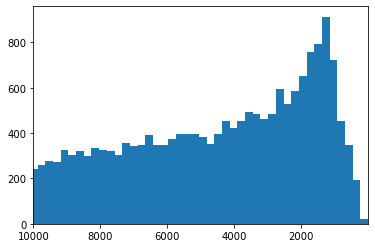

In [137]:
fig, ax = plt.subplots(1,1)
# fig.set_figheight(15)
# fig.set_figwidth(15)
# # ax.set_size_inches(10,15)
ax.set_xlim(10000)
ax.rev
ax.hist(df.palabras.values, bins=10000)

# data['pm2.5'].hist(bins=1000,grid=False)
# ax.set_xlabel("Palabras", fontsize=15)
# ax.set_ylabel("Documentos",fontsize=15)
plt.show()

In [139]:
np.argmax(df.palabras.values)

33328

In [145]:
print(df.iloc[np.argmax(df.palabras.values)].LINK)

https://www.corteconstitucional.gov.co/Relatoria/1996/C-037-96.htm


In [146]:
from bs4 import BeautifulSoup

In [148]:
main_soup = BeautifulSoup(df.iloc[np.argmax(df.palabras.values)].DOCUMENT, 'lxml')

In [149]:
main_soup.text

'LEY ESTATUTARIA JUSTICIA\n\n\n'

In [150]:
with open("sentencia_sucia.txt", "w") as f:
    f.write(df.iloc[np.argmax(df.palabras.values)].DOCUMENT)

In [35]:
X = ['mi mamá me mima', 'mi mamá me ama', 'amo a mi mamá']

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
vec = CountVectorizer(ngram_range=(1,3))
vec.fit(X)

CountVectorizer(ngram_range=(1, 3))

In [39]:
vec.vocabulary_

{'mi': 11,
 'mamá': 4,
 'me': 8,
 'mima': 14,
 'mi mamá': 12,
 'mamá me': 5,
 'me mima': 10,
 'mi mamá me': 13,
 'mamá me mima': 7,
 'ama': 0,
 'me ama': 9,
 'mamá me ama': 6,
 'amo': 1,
 'amo mi': 2,
 'amo mi mamá': 3}